In [1]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
# Import Numpy
import numpy as np
# Plot Import
import matplotlib.pyplot as plt
# For timer
import time
# Import OS
import os
# import local libs
import ecg_tools_lite as et

from statistics import mean

if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')

In [2]:
device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device, time.localtime().tm_mon, "/", time.localtime().tm_mday, "/", time.localtime().tm_year)

Device: cuda 11 / 19 / 2020


In [3]:
ecg_clean = et.load_ecg_file('all_chunks_fs1024_e24.npy')
ecg_noisy = et.load_ecg_file('all_chunks_fs1024_e06.npy')

trainloader = DataLoader( ecg_noisy, shuffle=True, num_workers=2 )
# testloader = DataLoader()

# Testing Autoencoder

In [4]:
# # Example
# m = nn.Conv1d(16, 33, 3, stride=2)
# n = nn.ConvTranspose1d(33, 16, 3, stride=1)
# input_test = torch.randn(20, 16, 50)
# ym = m(input_test)
# yn = n(ym)
# output = m(input_test)

In [5]:
# Smaller version of the chiang ae

# x1 = nn.Conv1d(1024, )

In [6]:
class ae_tester(nn.Module):
    def __init__(self, input_dim):
        super(ae_tester, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(
                in_channels=input_dim,
                out_channels=40, #filters
                kernel_size=16, #16
                stride=2,
                padding=int((16)/2)
            ),
            nn.Conv1d(40, 20, 16, stride=2, padding=int((16)/2)),
            nn.Conv1d(20, 20, 16, stride=2, padding=int((16)/2)),
            nn.Conv1d(20, 40, 16, stride=2, padding=int((16)/2)),
            nn.Conv1d(40, 1, 16, stride=1, padding=int((16)/2)),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(
                in_channels=1,
                out_channels=40,
                kernel_size=16,
                stride=1,
                # padding=int((16)/2)
            ),
            nn.ConvTranspose1d(40, 20, 16, stride=2),
            nn.ConvTranspose1d(20, 20, 16, stride=2),
            nn.ConvTranspose1d(20, 20, 16, stride=2),
            nn.ConvTranspose1d(20, 40, 16, stride=2),
            nn.ConvTranspose1d(40, input_dim, 16, stride=1),
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.decoder(x1)

        return x2

In [7]:
def train_model(model, train_set, lr, epochs):
    
    lr = 1e-3 if None else lr
    criterion = nn.MSELoss(size_average=False)
    optimizer = torch.optim.Adam(model.parameters())
    
    print( train_set.shape[0], train_set.shape[1])
    
    mean_losses = []

    for epoch in range(epochs):
        model.train()
        losses = []
        print(epoch)
        for x in train_set:
            # Added below to make it compatible with a 3 dimensional weight of the model
            # x = x.view(1, x.shape[0], x.shape[1])
            optimizer.zero_grad()
            x_prime = model(x)
            loss = criterion(x_prime, x)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        
        mean_loss = mean(losses)
        mean_losses.append(mean_loss)
        print(f"Epoch: {epoch}, Loss: {mean_loss}")
    return mean_losses


In [8]:
train_set = torch.from_numpy(ecg_clean)
train_set = train_set[0:4]

In [9]:
# train_set = train_set.view(train_set.shape[0], train_set.shape[1], 1)

In [11]:
model = ae_tester(train_set.shape[1])
model.double()
train_model( model, train_set, None, epochs=1)

4 1024
0


RuntimeError: Expected 3-dimensional input for 3-dimensional weight [40, 1024, 16], but got 2-dimensional input of size [1024, 1] instead

In [26]:
# mp = model.parameters()
# for i in mp:
#     print(i)

In [27]:
result_test = model.encoder(train_set)
result_final = model.decoder(result_test)

In [28]:
result_test.shape

torch.Size([4, 1, 2])

(4, 1, 2)

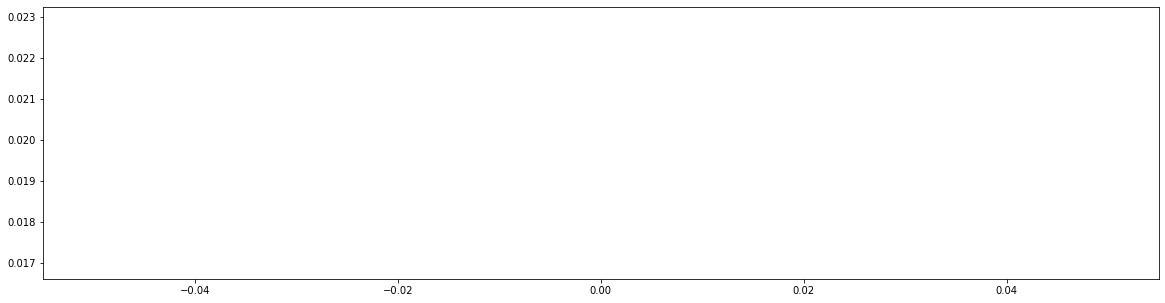

In [29]:
plot_res_final = result_test.detach().numpy()
plt.figure(figsize=(20,5))
plt.plot(plot_res_final[0][0:], c="red")
# plt.plot(train_set[0])
plot_res_final.shape

## Below sample

https://stackoverflow.com/questions/60591140/i-dont-understand-pytorch-input-sizes-of-conv1d-conv2d

Has an explanation, read again

In [30]:
# class ConvModel(nn.Module):
#     def __init__(self):
#         # input [B, 2, 18]
#         self.conv1 = nn.Conv1d(in_channels=2, out_channels=C1, kernel_size=3, padding=1)
#         # [B, C1, 18]
#         self.maxpool = nn.MaxPool1d(kernel_size=3, stride=3)
#         # [B, C1, 6]    (no alignment issue b/c 18 is a multiple of 3)
#         self.conv2 = nn.Conv1d(C1, C2, kernel_size=3, padding=1)
#         # [B, C2, 6]
#         self.fc1 = nn.Linear(C2*6, F1)
#         # [B, F1]
#         self.fc2 = nn.Linear(F1, F2)
#         # [B, F2]
#         self.fc2 = nn.Linear(F2, 2)
#         # [B, 2]

#     def forward(x):
#         x = F.relu(self.mp(self.conv1(x)))
#         x = self.maxpool(x)

#         x = F.relu(self.mp(self.conv2(x)))
#         x = self.maxpool(x)

#         x = x.flatten(1) # flatten the tensor starting at dimension 1

#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)

#         return x

In [31]:
# conv1 = nn.Conv2d(3, 1, 3)
# weight = conv1.weight.data.numpy()
# plt.imshow(weight[0, ...])

In [58]:
train_set.shape

torch.Size([4, 1024, 1])

In [144]:
trainloader = DataLoader( ecg_noisy, shuffle=True, num_workers=2 )
train_set = torch.from_numpy(ecg_clean)

In [145]:
train_set = train_set[0:10]
train_set = train_set.view(train_set.shape[0], 1024, 1)
train_set.shape

torch.Size([10, 1024, 1])

In [142]:
for i in train_set:
    i = i.view(1, 1024, 1)
    print( i.shape )

torch.Size([1, 1024, 1])
torch.Size([1, 1024, 1])
torch.Size([1, 1024, 1])
torch.Size([1, 1024, 1])
torch.Size([1, 1024, 1])
torch.Size([1, 1024, 1])
torch.Size([1, 1024, 1])
torch.Size([1, 1024, 1])
torch.Size([1, 1024, 1])
torch.Size([1, 1024, 1])


In [146]:
# # Example
# Encoder part
e1 = nn.Conv1d(1024, 40, 16, stride=2, padding=int(16/2))
e1.double()
# Decoder part
d1 = nn.ConvTranspose1d(40, 1024, 1, stride=2)
# d2 = nn.ConvTranspose1d(1024, 1, 1, stride=1)
d1.double()
# d2.double()
for i in train_set:
    i = i.view(1, i.shape[0], i.shape[1])
    
    x = e1(i)
    x = d1(x)
    # x = d2(x)

result_set = x.detach().numpy()

In [147]:
result_set.shape

(1, 1024, 1)

In [156]:
class ae_sampler(nn.Module):
    def __init__(self):
        super(ae_sampler, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(1024, 40, 16, stride=2, padding=int(16/2))
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(40, 1024, 1, stride=2)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [157]:
def train_model( model, train_set, lr, epochs):
    lr = 1e-3 if None else lr
    criterion = nn.MSELoss( size_average=False )
    optimizer = torch.optim.Adam( model.parameters() )

    mean_losses = []
    # Iterate for each epoch
    for epoch in range( epochs ):
        model.train()
        losses = []
        # Iterate the entire data set
        for i in train_set:
            i = i.view( 1, i.shape[0], i.shape[1] )

            optimizer.zero_grad()
            x_prime = model(i)
            loss = criterion(x_prime, i)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        mean_loss = mean(losses)
        mean_losses.append(mean_loss)
        print(f"Epoch: {epoch}, Loss: {mean_loss}")

    return mean_losses

In [160]:
model = ae_sampler()
model.double()
losses = train_model( model, train_set, None, epochs=10)

Epoch: 0, Loss: 0.816025217969512
Epoch: 1, Loss: 0.5626386561573398
Epoch: 2, Loss: 0.42038431135573584
Epoch: 3, Loss: 0.3587747903985715
Epoch: 4, Loss: 0.32477576830203747
Epoch: 5, Loss: 0.28795405654025086
Epoch: 6, Loss: 0.24597467889364738
Epoch: 7, Loss: 0.20418864997316122
Epoch: 8, Loss: 0.16452410002224727
Epoch: 9, Loss: 0.12635164325432888


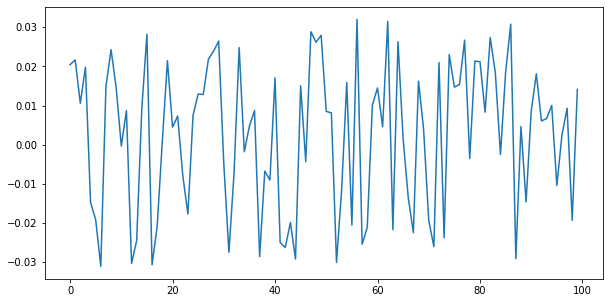

In [159]:
plt.figure( figsize=(10,5))
plt.plot( result_set[0][0:100][:] )